In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# set visualization style
sns.set(style='whitegrid', palette='muted')
plt.rcParams['figure.figsize'] = (12, 6)


## 1. Data Loading & Preparation
I will start from the preprocessed data in understanding_data.ipynb 

In [ ]:
# load datasets
train = pd.read_csv('data/train.csv', parse_dates=['trans_date_trans_time', 'dob'])
test = pd.read_csv('data/test.csv', parse_dates=['trans_date_trans_time', 'dob'])

In [ ]:
# verify shapes
print(f"Train shape: {train.shape}, Test shape: {test.shape}")
print(f"Fraud rate - Train: {train['is_fraud'].mean():.4f}, Test: {test['is_fraud'].mean():.4f}")

Train shape: (1296675, 25), Test shape: (555719, 25)
Fraud rate - Train: 0.0058, Test: 0.0039


## 2. Geospatial Features
### 2.1 Transaction Distance Calculation

In [4]:
def calculate_distance(row):
    """Calculate distance between cardholder and merchant using geodesic"""
    card_loc = (row['lat'], row['long'])
    merch_loc = (row['merch_lat'], row['merch_long'])
    return geodesic(card_loc, merch_loc).km

In [5]:
for df in [train, test]:
    df['distance_km'] = df.apply(calculate_distance, axis=1)
    df['log_distance'] = np.log1p(df['distance_km'])
    

### 2.2 Distance Fraud Analysis

In [ ]:
# distance Fraud Analysis
bins = [0, 10, 50, 100, 200, 500, 1000, float('inf')]
labels = ['<10km', '10-50km', '50-100km', '100-200km', '200-500km', '500-1000km', '>1000km']
train['distance_bin'] = pd.cut(train['distance_km'], bins=bins, labels=labels)
distance_fraud = train.groupby('distance_bin')['is_fraud'].mean().reset_index()

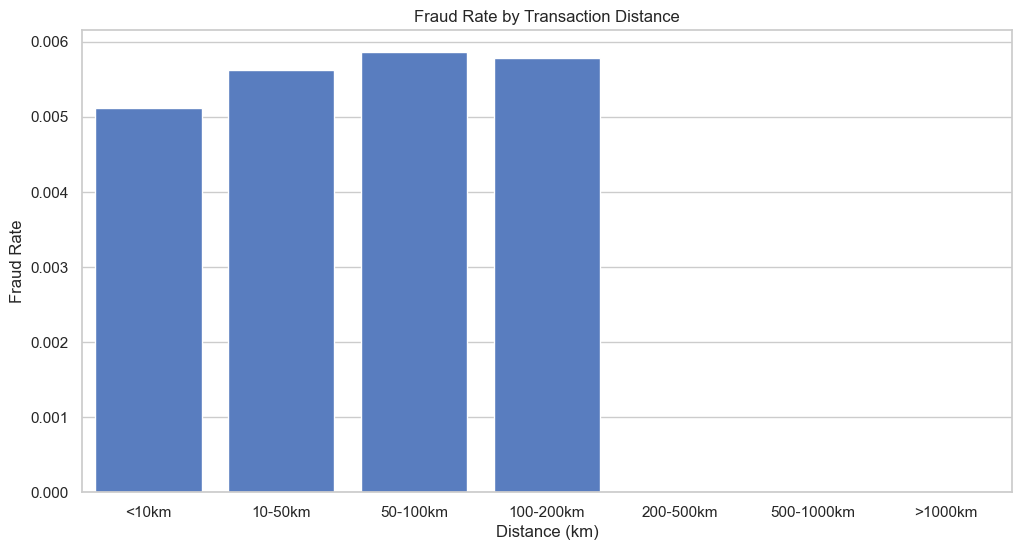

In [ ]:
# visualize
plt.figure(figsize=(12, 6))
sns.barplot(x='distance_bin', y='is_fraud', data=distance_fraud, order=labels)
plt.title('Fraud Rate by Transaction Distance')
plt.xlabel('Distance (km)')
plt.ylabel('Fraud Rate')
plt.show()

## 3. Temporal Features
### 3.1 Time Feature Extraction

In [ ]:
# define high-risk night hours (based on SQL analysis)
NIGHT_HOURS = [22, 23, 0, 1, 2, 3]

for df in [train, test]:
    # extract time components
    df['trans_hour'] = df['trans_date_trans_time'].dt.hour
    df['trans_day'] = df['trans_date_trans_time'].dt.day_name()
    df['trans_month'] = df['trans_date_trans_time'].dt.month
    
    # create fraud risk flags
    df['is_night'] = df['trans_hour'].isin(NIGHT_HOURS).astype(int)
    df['is_weekend'] = df['trans_date_trans_time'].dt.dayofweek.isin([5,6]).astype(int)
    df['is_saturday'] = (df['trans_day'] == 'Saturday').astype(int)

### 3.2 Hourly Fraud Pattern Visualization

In [ ]:
# calculate hourly fraud rates
hourly_fraud = train.groupby('trans_hour')['is_fraud'].mean().reset_index()

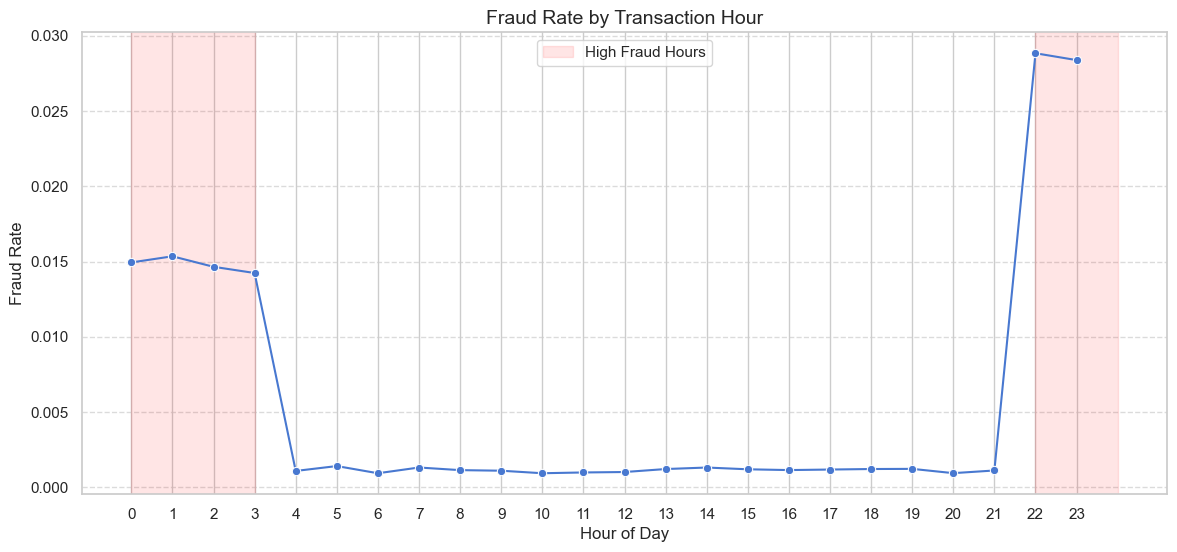

In [ ]:
# visualize
plt.figure(figsize=(14, 6))
sns.lineplot(x='trans_hour', y='is_fraud', data=hourly_fraud, marker='o')
plt.axvspan(22, 24, color='red', alpha=0.1, label='High Fraud Hours')
plt.axvspan(0, 3, color='red', alpha=0.1)
plt.title('Fraud Rate by Transaction Hour', fontsize=14)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Fraud Rate', fontsize=12)
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

## 4. Risk Flag Features
Based on SQL analysis findings

In [ ]:
# define high-risk groups
HIGH_RISK_CATEGORIES = ['shopping_net', 'misc_net', 'grocery_pos']
HIGH_RISK_STATES = ['RI', 'AK', 'NV']

for df in [train, test]:
    # category risk flags
    df['high_risk_category'] = df['category'].isin(HIGH_RISK_CATEGORIES).astype(int)
    
    # geographic risk flags
    df['high_risk_state'] = df['state'].isin(HIGH_RISK_STATES).astype(int)
    df['small_city'] = (df['city_pop'] < 10000).astype(int)
    
    # transaction value flags
    df['high_value_txn'] = (df['amt'] > 500).astype(int)
    df['medium_value_txn'] = ((df['amt'] >= 100) & (df['amt'] <= 500)).astype(int)
    
    # demographic features
    df['age'] = (pd.Timestamp('now') - df['dob']).dt.days // 365
    df['senior_citizen'] = (df['age'] >= 65).astype(int)

## 5. Behavioral Features
### 5.1 Transaction Frequency Analysis

In [ ]:
# behavioral features
for df in [train, test]:
    df['trans_date'] = df['trans_date_trans_time'].dt.date
    df['daily_freq'] = df.groupby(['cc_num', 'trans_date'])['trans_num'].transform('count')
    df['freq_risk'] = (df['daily_freq'] > 5).astype(int)

### 5.2 Category Risk Visualization

In [ ]:
# calculate fraud rates by category
category_fraud = train.groupby('category')['is_fraud'].mean().sort_values(ascending=False)


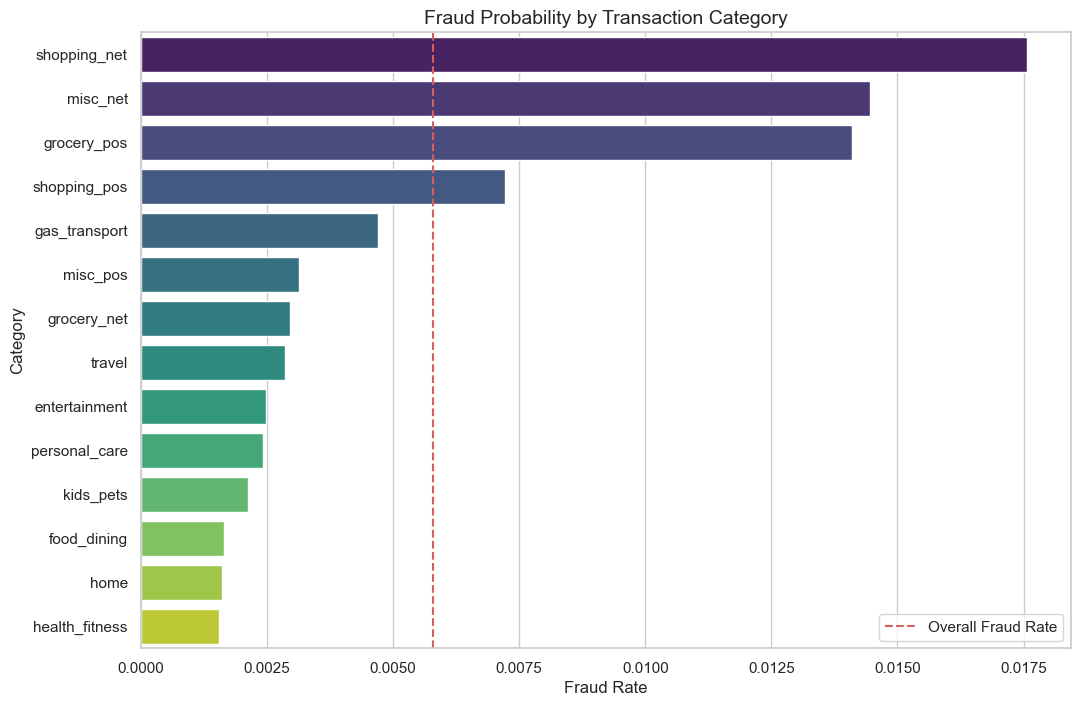

In [ ]:
# visualize
plt.figure(figsize=(12, 8))
sns.barplot(y=category_fraud.index, x=category_fraud.values, palette='viridis')
plt.title('Fraud Probability by Transaction Category', fontsize=14)
plt.xlabel('Fraud Rate', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.axvline(x=train['is_fraud'].mean(), color='r', linestyle='--', label='Overall Fraud Rate')
plt.legend()
plt.show()

## 6. Feature Correlation Analysis
Examine relationships between new features and fraud

In [ ]:
# select engineered features
features = [
    'distance_km', 'is_night', 'high_risk_category',
    'high_risk_state', 'medium_value_txn', 'high_value_txn', 'age',
    'daily_freq', 'freq_risk'
]

# calculate correlation matrix
corr_matrix = train[features + ['is_fraud']].corr()

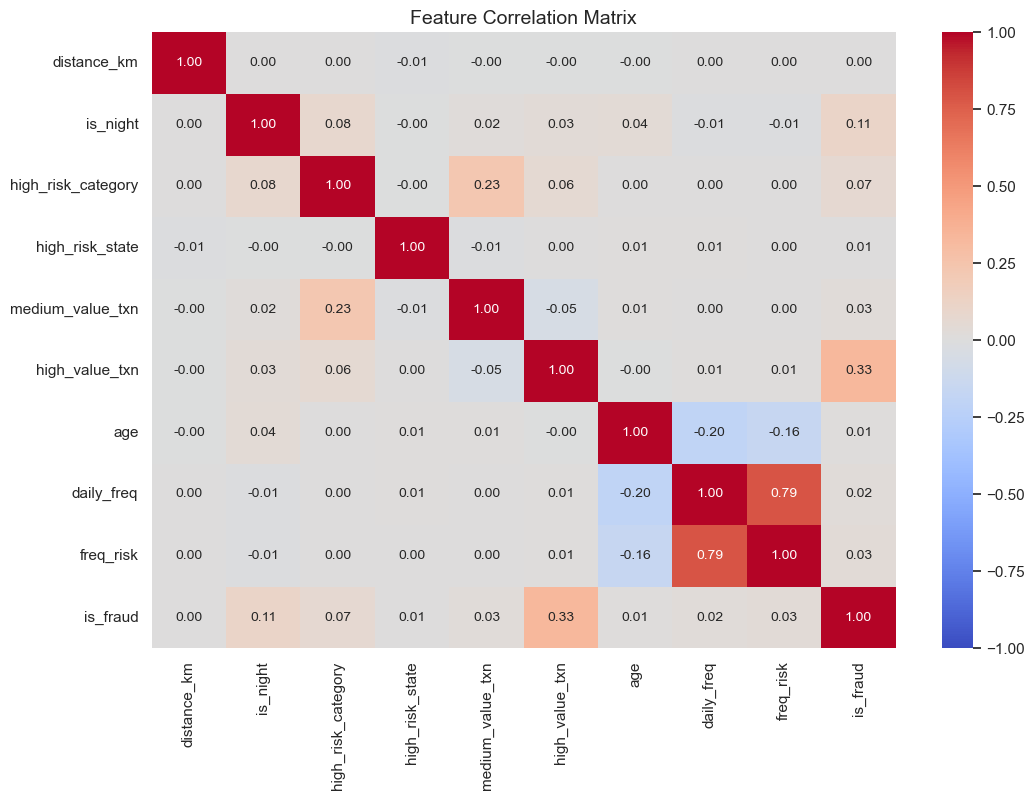

In [ ]:
# visualize
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f',
            annot_kws={'size': 10}, vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix', fontsize=14)
plt.show()

## 7. Final Dataset Preparation
Prepare datasets for modeling

In [ ]:
# additional demographic features
train['age_bin_30-45'] = ((train['age'] >= 30) & (train['age'] <= 45)).astype(int)
train['age_bin_46-60'] = ((train['age'] >= 46) & (train['age'] <= 60)).astype(int)
train['age_bin_60+'] = (train['age'] > 60).astype(int)

test['age_bin_30-45'] = ((test['age'] >= 30) & (test['age'] <= 45)).astype(int)
test['age_bin_46-60'] = ((test['age'] >= 46) & (test['age'] <= 60)).astype(int)
test['age_bin_60+'] = (test['age'] > 60).astype(int)

In [ ]:
# final dataset preparation
category_risk = train.groupby('category')['is_fraud'].mean().to_dict()
merchant_risk = train.groupby('merchant')['is_fraud'].mean().to_dict()
for df in [train, test]:
    df['category_risk_score'] = df['category'].map(category_risk).fillna(0)
    df['merchant_risk_score'] = df['merchant'].map(merchant_risk).fillna(0)


engineered_features = [
    'trans_hour', 'is_night', 'is_weekend', 'is_saturday',
    'distance_km', 'log_distance',
    'high_risk_category', 'category_risk_score', 'merchant_risk_score',
    'high_risk_state', 'small_city', 'high_value_txn', 'medium_value_txn',
    'age', 'age_bin_30-45', 'age_bin_46-60', 'age_bin_60+',
    'daily_freq', 'freq_risk'
]

In [ ]:
# select final features
final_features = ['amt', 'gender'] + engineered_features + ['is_fraud']


In [ ]:
# create final datasets
train_final = train[final_features]
test_final = test[final_features]

In [ ]:
# save engineered datasets
train_final.to_csv('engineered_data/fraudTrain_engineered.csv', index=False)
test_final.to_csv('engineered_data/fraudTest_engineered.csv', index=False)
print(f"Final train shape: {train_final.shape}, Test shape: {test_final.shape}")
print("Feature engineering complete! Datasets saved to /engineered_data")

Final train shape: (1296675, 22), Test shape: (555719, 22)
Feature engineering complete! Datasets saved to /engineered_data
